# Min-min Max-max

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

from lightgbm import LGBMRegressor

import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

e:\programs\py\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
pd.set_option('max_columns', 100)

In [3]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [4]:
df_train_X = pd.read_csv('../Data/train_data.csv')
df_train_Y = pd.read_csv('../Data/train_answers.csv')

In [5]:
df_test = pd.read_csv('../Data/test_data.csv')

In [6]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

In [7]:
X_pred = df_train_X.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                           'Ymin': [min, max, 'mean', 'std', 'median'],
                                           'Xmax': [min, max, 'mean', 'std', 'median'],
                                           'Ymax': [min, max, 'mean', 'std', 'median'],
                                           'userId': ['count', 'sum']})

In [8]:
X_pred = X_pred.merge(df_train_Y, on='itemId', how='inner')

In [9]:
X_pred["iou"] = X_pred[[('Xmin', 'min'),('Ymin', 'min'), ('Xmax', 'max'), ('Ymax', 'max'), 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [10]:
X_pred['iou'].mean()

0.5809800227327839

In [11]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,917.0,483,511,501.333333,15.885003,510.0,1160,1331,1248.666667,85.675745,1255.0,3,2767,198,827,649,1340,0.520083
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,559.0,402,427,416.333333,12.897028,420.0,852,858,855.333333,3.055050,856.0,3,2767,26,605,433,847,0.723581
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,603.0,561,621,596.666667,31.564748,608.0,950,981,966.666667,15.631165,969.0,3,2767,233,698,622,920,0.392782
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,367.0,97,324,269.200000,97.497179,316.0,369,491,459.200000,51.363411,477.0,5,5690,61,368,329,530,0.673495
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,560.0,126,388,256.166667,141.158658,254.0,624,884,756.833333,137.917971,759.5,6,2820,30,536,328,813,0.359999


### Прогнозирование отклонения

In [12]:
X_pred['Volume'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]) *\
                    (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['Mean_Volume'] = (X_pred[('Xmax', 'mean')] - X_pred[('Xmin', 'mean')]) *\
                    (X_pred[('Ymax', 'mean')] - X_pred[('Ymin', 'mean')])
    
X_pred['Min_Volume'] = abs((X_pred[('Xmax', 'min')] - X_pred[('Xmin', 'max')]) *\
                    (X_pred[('Ymax', 'min')] - X_pred[('Ymin', 'max')]))
    
X_pred['X_Y_ratio'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')])/\
                            (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['X_length'] = X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]
X_pred['Y_length'] = X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')]

X_pred['Diag_length'] = np.sqrt(X_pred['X_length']**2 + X_pred['Y_length']**2)

In [13]:
X_pred['X_Y_ratio'] = X_pred['X_Y_ratio'].replace(np.inf, 2)
X_pred.fillna(1, inplace=True)

In [14]:
Xmin_dtarg = X_pred['Xmin_true'] - X_pred[('Xmin', 'min')]
Ymin_dtarg = X_pred['Ymin_true'] - X_pred[('Ymin', 'min')]
Xmax_dtarg = X_pred['Xmax_true'] - X_pred[('Xmax', 'max')]
Ymax_dtarg = X_pred['Ymax_true'] - X_pred[('Ymax', 'max')]

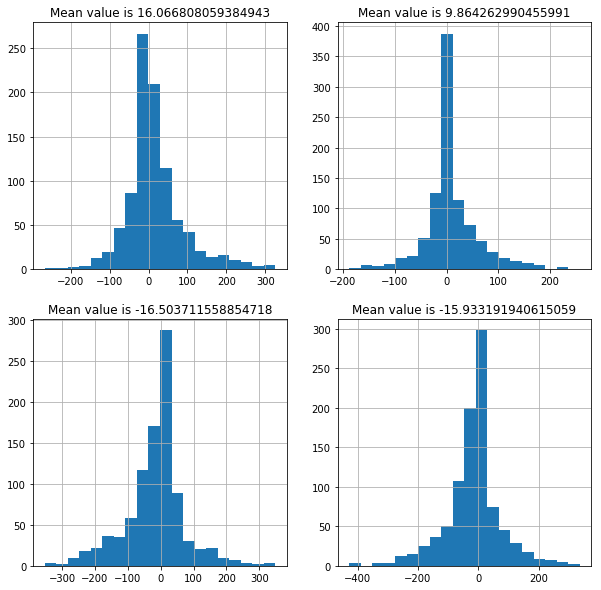

In [15]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
Xmin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmin_dtarg.mean()));

plt.subplot(2, 2, 2)
Ymin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymin_dtarg.mean()));

plt.subplot(2, 2, 3)
Xmax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmax_dtarg.mean()));

plt.subplot(2, 2, 4)
Ymax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymax_dtarg.mean()));

Качество, если добавить константы отклонений к прогнозам

In [16]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,917.0,483,511,501.333333,15.885003,510.0,1160,1331,1248.666667,85.675745,1255.0,3,2767,198,827,649,1340,0.520083,150120,104610.000000,64155,0.863309,360,417,550.898357
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,559.0,402,427,416.333333,12.897028,420.0,852,858,855.333333,3.055050,856.0,3,2767,26,605,433,847,0.723581,106145,96189.777778,86292,1.187291,355,299,464.140065
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,603.0,561,621,596.666667,31.564748,608.0,950,981,966.666667,15.631165,969.0,3,2767,233,698,622,920,0.392782,219075,191652.333333,160648,1.509186,575,381,689.772426
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,367.0,97,324,269.200000,97.497179,316.0,369,491,459.200000,51.363411,477.0,5,5690,61,368,329,530,0.673495,35742,16642.080000,162,1.876812,259,138,293.470612
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,560.0,126,388,256.166667,141.158658,254.0,624,884,756.833333,137.917971,759.5,6,2820,30,536,328,813,0.359999,229295,45790.000000,15540,0.626446,379,605,713.908958


In [17]:
train_data = X_pred.drop(columns=['itemId', 'Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou'], axis=1)

In [18]:
train_data.columns

Index([    ('Xmin', 'min'),     ('Xmin', 'max'),    ('Xmin', 'mean'),
           ('Xmin', 'std'),  ('Xmin', 'median'),     ('Ymin', 'min'),
           ('Ymin', 'max'),    ('Ymin', 'mean'),     ('Ymin', 'std'),
        ('Ymin', 'median'),     ('Xmax', 'min'),     ('Xmax', 'max'),
          ('Xmax', 'mean'),     ('Xmax', 'std'),  ('Xmax', 'median'),
           ('Ymax', 'min'),     ('Ymax', 'max'),    ('Ymax', 'mean'),
           ('Ymax', 'std'),  ('Ymax', 'median'), ('userId', 'count'),
         ('userId', 'sum'),            'Volume',       'Mean_Volume',
              'Min_Volume',         'X_Y_ratio',          'X_length',
                'Y_length',       'Diag_length'],
      dtype='object')

In [103]:
class my_filter_model():
    def __init__(self, model, filtercond):
        self.model = model
        self.filtercond = filtercond
        
    def fit(self, X, y):
        X_train_filt = X.loc[self.filtercond]
        y_train_filt = y[self.filtercond]
        self.model.fit(X_train_filt, y_train_filt)
        return self.model
    
    def predict(self, X):
        return self.model.predict(X)

    def custom_cv(self, X, y, cv=4, dofilter=False):
        preds = np.zeros(X.shape[0])

        # Cross validation
        foldlen = X.shape[0] // cv
        for i in range(cv):
            if i == (cv-1):
                X_test = X.iloc[i*foldlen:, :]
                X_train = X.iloc[:i*foldlen, :]
                y_test = y[i*foldlen:]
                y_train = y[:i*foldlen]
                if dofilter:
                    train_cond = self.filtercond[:i*foldlen]
            else:          
                X_test = X.iloc[i*foldlen:(i+1)*foldlen, :]
                X_train = pd.concat([X.iloc[:i*foldlen, :], X.iloc[(i+1)*foldlen:, :]])
                y_test = y[i*foldlen:(i+1)*foldlen]
                y_train = pd.concat([y[:i*foldlen], y[(i+1)*foldlen:]])
                if dofilter:
                    train_cond = pd.concat([self.filtercond[:i*foldlen], self.filtercond[(i+1)*foldlen:]])
            if dofilter:
                X_train_filt = X_train.loc[train_cond]
                y_train_filt = y_train[train_cond]

            # Model fit predict
            self.model.fit(X_train_filt, y_train_filt)
            fold_preds = self.model.predict(X_test)
            if i == (cv-1):
                preds[i*foldlen:] = fold_preds
            else:
                preds[i*foldlen:(i+1)*foldlen] = fold_preds
        return preds

### Random Forest

In [19]:
with open ('filtercond.pikle', 'rb') as F:
    filtercond = pickle.load(F)

In [156]:
model_Xmin = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Xmin = cross_val_predict(model_Xmin, train_data, Xmin_dtarg, cv=4, n_jobs=-1)

In [157]:
model_Ymin = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Ymin = cross_val_predict(model_Ymin, train_data, Ymin_dtarg, cv=4, n_jobs=-1)

In [158]:
model_Xmax = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Xmax = cross_val_predict(model_Xmax, train_data, Xmax_dtarg, cv=4, n_jobs=-1)

In [159]:
model_Ymax = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Ymax = cross_val_predict(model_Ymax, train_data, Ymax_dtarg, cv=4, n_jobs=-1)

## OR custom cv with filtering

In [136]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Xmin = my_filter_model(model, filtercond)
preds_Xmin = model_Xmin.custom_cv(train_data, Xmin_dtarg, dofilter=True)

In [137]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Ymin = my_filter_model(model, filtercond)
preds_Ymin = model_Ymin.custom_cv(train_data, Ymin_dtarg, dofilter=True)

In [138]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Xmax = my_filter_model(model, filtercond)
preds_Xmax = model_Xmax.custom_cv(train_data, Xmax_dtarg, dofilter=True)

In [139]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Ymax = my_filter_model(model, filtercond)
preds_Ymax = model_Ymax.custom_cv(train_data, Ymax_dtarg, dofilter=True)

In [140]:
pd.Series(preds_Xmin).describe()

count    943.000000
mean      18.302757
std       36.184020
min     -115.472000
25%       -0.388000
50%       13.252000
75%       38.014000
max      147.840000
dtype: float64

### LightGBM

In [18]:
model_Xmin = LGBMRegressor()

### Score

In [17]:
X_rez = X_pred.copy()

In [133]:
X_rez['Xmin_pred'] = X_rez[('Xmin', 'min')] + preds_Xmin/3
X_rez['Ymin_pred'] = X_rez[('Ymin', 'min')] + preds_Ymin/3
X_rez['Xmax_pred'] = X_rez[('Xmax', 'max')] + preds_Xmax/3
X_rez['Ymax_pred'] = X_rez[('Ymax', 'max')] + preds_Ymax/2


X_rez["iou"] = X_rez[['Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [134]:
X_rez['iou'].mean()

0.5819978075119252

In [175]:

X_rez['Xmin_diff'] = X_rez['Xmin_true'] - X_rez['Xmin_pred']
X_rez['Ymin_diff'] = X_rez['Ymin_true'] - X_rez['Ymin_pred']
X_rez['Xmax_diff'] = X_rez['Xmax_true'] - X_rez['Xmax_pred']
X_rez['Ymax_diff'] = X_rez['Ymax_true'] - X_rez['Ymax_pred']

X_rez['Sum_err'] = abs(X_rez['Xmin_diff']) + abs(X_rez['Ymin_diff']) + \
                            abs(X_rez['Xmax_diff']) + abs(X_rez['Ymax_diff'])

In [173]:
X_rez[['Xmin_diff', 'Ymin_diff','Xmax_diff','Ymax_diff']].describe()

,Xmin_diff,Ymin_diff,Xmax_diff,Ymax_diff
count,943.000000,943.000000,943.000000,943.000000
mean,10.117855,6.234093,-10.361848,-8.205111
std,70.029962,51.638762,87.641329,84.103437
min,-249.071333,-183.188000,-318.729333,-424.195000
25%,-27.623667,-16.040667,-50.893333,-45.028000
50%,-1.552667,-0.349333,0.470000,-3.712000
75%,35.027667,23.592667,28.254000,21.888000
max,310.074000,239.982667,338.200667,335.927000


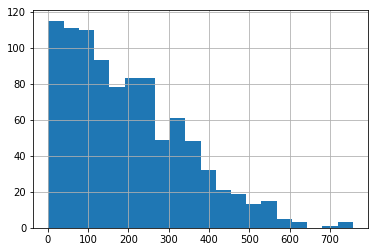

In [179]:
X_rez['Sum_err'].hist(bins=20)

In [187]:
X_rez[X_rez['Sum_err'] > 400].describe()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred,Xmin_diff,Ymin_diff,Xmax_diff,Ymax_diff,Sum_err
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,16578.989130,71.108696,253.826087,143.413554,72.359521,127.331522,465.630435,573.934783,515.741201,41.710399,512.559783,610.500000,807.728261,726.677539,80.236834,738.739130,914.565217,1096.750000,1031.941347,72.813650,1049.559783,5.652174,4916.065217,149.880435,510.554348,735.913043,1052.869565,0.443496,473426.108696,311002.056403,162426.48913,1.190172,736.619565,631.119565,975.956968,84.136254,474.849130,794.926043,1073.919326,65.744181,35.705217,-59.013000,-21.049761,495.452587
std,10788.771596,53.452342,162.248596,70.739208,62.266970,72.290025,226.548431,246.776484,235.684280,26.840023,237.035745,183.319783,146.331184,139.677679,70.558116,151.727588,268.943938,252.484212,245.995765,65.033627,248.604996,2.535180,2223.799742,122.450155,247.077083,183.512053,271.841228,0.095298,163715.724856,132657.206093,136166.58728,0.245431,156.463726,130.237217,172.463778,42.836281,225.766977,132.439369,251.393073,125.179915,88.675243,174.443503,165.233523,77.918887
min,78.000000,11.000000,32.000000,21.666667,9.073772,22.000000,40.000000,62.000000,54.000000,4.163332,60.000000,102.000000,377.000000,260.100000,6.506407,251.000000,300.000000,528.000000,478.000000,4.098780,502.000000,3.000000,952.000000,0.000000,80.000000,230.000000,517.000000,0.124629,155600.000000,46256.765625,55.00000,0.467742,348.000000,389.000000,557.961468,29.007333,70.957333,384.160000,525.496000,-149.755333,-167.410667,-318.729333,-424.195000,400.092667
25%,7780.250000,34.750000,131.000000,87.075000,31.632695,73.375000,304.000000,392.500000,351.250000,21.474548,331.125000,490.500000,697.250000,628.608333,31.639807,627.500000,712.500000,903.500000,855.333333,32.710853,856.500000,3.000000,3134.500000,25.750000,299.250000,623.500000,859.250000,0.405372,354157.000000,206346.988445,36858.25000,1.018394,609.750000,532.250000,858.343601,55.003000,312.227667,710.001333,885.163000,-43.942833,-35.011833,-207.504667,-129.560000,441.634583
50%,15966.500000,54.000000,214.000000,135.900000,50.980758,108.500000,457.000000,566.500000,505.083333,36.895838,505.750000,626.500000,856.000000,733.500000,61.285402,763.500000,908.000000,1109.500000,1061.225000,55.670103,1077.000000,5.000000,4756.000000,136.500000,479.000000,709.000000,1052.500000,0.452939,463620.000000,310131.657143,138188.50000,1.244195,756.500000,617.000000,978.895671,73.886333,465.490333,833.597667,1077.776500,63.569333,38.822000,-126.751333,-50.840500,472.438167
75%,25601.250000,98.000000,309.500000,197.416667,92.488382,176.250000,629.000000,765.500000,680.937500,57.551668,676.875000,770.000000,922.250000,841.341667,106.037254,862.500000,1093.750000,1282.250000,1195.750000,92.912805,1230.125000,8.000000,6412.500000,256.500000,704.000000,884.500000,1228.750000,0.504503,575416.500000,384571.745313,250841.50000,1.383651,864.750000,692.500000,1104.202850,105.131500,633.054000,892.908500,1216.340250,167.842167,99.522500,68.761333,84.441500,540.064917
max,35962.000000,276.000000,965.000000,339.750000,371.037869,332.000000,1103.000000,1230.000000,1169.20000

In [188]:
X_rez[X_rez['Sum_err'] <= 400].describe()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred,Xmin_diff,Ymin_diff,Xmax_diff,Ymax_diff,Sum_err
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,18444.216216,66.534665,166.007051,108.841279,39.289547,103.866627,633.493537,695.002350,659.021465,24.120215,655.670388,341.276146,448.618096,405.607253,42.723143,413.399530,853.764982,947.203290,912.343477,37.199561,921.186251,5.660400,5034.142186,75.822562,639.567568,438.094007,934.291422,0.598078,163025.482961,104267.864459,53868.364277,1.261950,382.083431,313.709753,497.714970,71.718363,636.519542,443.196271,941.107922,4.104198,3.048025,-5.102264,-6.816501,166.721207
std,10369.506866,54.294531,134.794903,77.570354,46.088759,80.343191,258.446041,258.735954,255.931730,28.999325,256.959558,211.323694,252.402696,229.616774,47.198663,235.802285,268.068953,273.534361,266.067956,41.711548,268.626777,2.698334,2628.732357,64.505870,257.963634,255.172483,284.481100,0.139015,166345.997999,113642.697043,82668.424429,0.297542,239.905033,198.965044,306.298834,47.001061,257.040340,247.533569,273.061799,58.191682,44.823786,70.502617,69.973267,108.954869
min,5.000000,-4.000000,20.000000,16.666667,0.000000,15.000000,48.000000,75.000000,71.666667,0.000000,74.000000,14.000000,36.000000,35.666667,0.000000,36.000000,188.000000,383.000000,379.333333,0.000000,379.000000,3.000000,335.000000,-1.000000,21.000000,37.000000,389.000000,-0.000000,0.000000,0.000000,0.000000,0.544413,0.000000,0.000000,0.000000,9.442667,58.866667,36.849333,381.883000,-249.071333,-183.188000,-238.752000,-264.306000,2.218667
25%,9460.500000,33.000000,70.000000,54.100000,10.299523,50.250000,449.000000,497.500000,474.516667,6.083904,472.500000,163.500000,237.000000,214.500000,11.515889,213.500000,643.000000,730.000000,701.277778,9.351693,710.000000,3.000000,2963.500000,32.000000,456.000000,233.000000,710.000000,0.517696,29916.000000,16946.319444,2389.000000,1.067341,185.000000,152.500000,250.429630,43.112333,452.986667,237.463333,723.024500,-25.700333,-15.560333,-39.411667,-38.583000,72.712833
50%,18994.000000,48.000000,124.000000,84.000000,24.924648,77.000000,624.000000,697.000000,656.333333,15.943477,653.000000,318.000000,424.000000,379.800000,27.196814,386.000000,837.000000,928.000000,894.222222,24.260393,905.000000,5.000000,4571.000000,53.000000,636.000000,400.000000,918.000000,0.593580,106145.000000,65421.960000,16647.000000,1.281124,360.000000,293.000000,472.410838,56.709333,626.743333,423.876667,920.027000,-2.102000,-0.878667,1.104000,-2.867000,152.020333
75%,27483.000000,80.000000,215.500000,139.125000,48.308180,129.000000,809.500000,867.000000,832.500000,32.710317,831.000000,488.500000,638.000000,572.920635,55.149187,580.000000,1047.000000,1139.500000,1104.300000,49.079513,1106.000000,7.500000,6521.500000,101.000000,817.500000,626.500000,1120.000000,0.689115,246672.000000,156410.722222,66342.500000,1.444967,555.000000,449.500000,716.212802,82.151667,813.173000,632.524000,1131.456500,30.275333,19.356333,26.386333,18.746500,249.395500
max,35873.000000,442.000000,921.000000,533.000000,359.417584,556.500000,1508.000000,1532.000000,1518.000000,279.762399,151

### Feature importances

In [120]:
# model_Xmin_fitted = model_Xmin.fit(train_data, Xmin_dtarg)

In [121]:
# feat_emp = pd.Series(dict(zip(train_data.columns, model_Xmin_fitted.feature_importances_))).sort_values(ascending=False)

### Train models on whole data

In [122]:
model_Xmin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmin_dtarg)

model_Ymin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymin_dtarg)

model_Xmax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmax_dtarg)

model_Ymax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymax_dtarg)

## Train filter model

In [141]:
model_Xmin = model_Xmin.fit(train_data, Xmin_dtarg)

model_Ymin = model_Ymin.fit(train_data, Ymin_dtarg)

model_Xmax = model_Xmax.fit(train_data, Xmax_dtarg)

model_Ymax = model_Ymax.fit(train_data, Ymax_dtarg)

## Test dataset preparation

In [142]:
X_test = df_test.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                        'Ymin': [min, max, 'mean', 'std', 'median'],
                                        'Xmax': [min, max, 'mean', 'std', 'median'],
                                        'Ymax': [min, max, 'mean', 'std', 'median'],
                                        'userId': ['count', 'sum']})

In [143]:
X_test['Volume'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]) *\
                    (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])
    
X_test['Mean_Volume'] = (X_test[('Xmax', 'mean')] - X_test[('Xmin', 'mean')]) *\
                (X_test[('Ymax', 'mean')] - X_test[('Ymin', 'mean')])
    
X_test['Min_Volume'] = abs((X_test[('Xmax', 'min')] - X_test[('Xmin', 'max')]) *\
                    (X_test[('Ymax', 'min')] - X_test[('Ymin', 'max')]))
    
    
X_test['X_Y_ratio'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')])/\
                            (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])    
    
X_test['X_length'] = X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]
X_test['Y_length'] = X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')]

X_test['Diag_length'] = np.sqrt(X_test['X_length']**2 + X_test['Y_length']**2)

In [144]:
X_test['X_Y_ratio'] = X_test['X_Y_ratio'].replace(np.inf, 2)
X_test.fillna(1, inplace=True)

In [145]:
preds_Xmin = model_Xmin.predict(X_test)
preds_Ymin = model_Ymin.predict(X_test)
preds_Xmax = model_Xmax.predict(X_test)
preds_Ymax = model_Ymax.predict(X_test)

In [146]:
X_test['Xmin_pred'] = X_test[('Xmin', 'min')] + preds_Xmin/3
X_test['Ymin_pred'] = X_test[('Ymin', 'min')] + preds_Ymin/3
X_test['Xmax_pred'] = X_test[('Xmax', 'max')] + preds_Xmax/3
X_test['Ymax_pred'] = X_test[('Ymax', 'max')] + preds_Ymax/2

In [147]:
X_test['itemId'] = X_test.index
X_test = X_test[['itemId', 'Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred']]

In [149]:
# X_test.to_csv('../Submits/submit18.csv', header=False, index=False)

In [132]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)",...,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,...,649,1340,0.520083,150120,104610.000000,64155,0.863309,360,417,550.898357
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,...,433,847,0.723581,106145,96189.777778,86292,1.187291,355,299,464.140065
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,...,622,920,0.392782,219075,191652.333333,160648,1.509186,575,381,689.772426
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,...,329,530,0.673495,35742,16642.080000,162,1.876812,259,138,293.470612
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,...,328,813,0.359999,229295,45790.000000,15540,0.626446,379,605,713.908958


In [133]:
X_test.head( )

,itemId,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred
,,,,,
itemId,,,,,
18,18,122.493333,631.728000,765.872667,1141.791
19,19,29.498667,563.654667,123.372000,724.349
33,33,28.682000,382.785333,406.091333,651.389
62,62,51.265333,829.119333,629.235333,1259.410
114,114,43.971333,571.029333,221.497333,757.308


## Test prediction

In [46]:
test_pred = df_test.groupby('itemId').agg({'Xmin': min,
                                              'Ymin': min,
                                              'Xmax': max,
                                              'Ymax': max})

In [47]:
test_pred['itemId'] = test_pred.index
test_pred = test_pred[['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]

In [30]:
test_pred.to_csv('../Submits/submit3.csv', header=False, index=False)

In [31]:
test_pred

,itemId,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,126,634,764,1132
19,19,27,559,119,729
33,33,21,380,414,652
62,62,35,824,639,1262
114,114,41,570,216,780
146,146,17,211,643,1118
156,156,74,802,160,887
163,163,21,317,213,465
164,164,4,146,401,681
